### we’ll be using the K-nearest neighbors algorithm to predict how many points NBA players scored in the 2013-2014 season

In [4]:
import pandas as pd
nba = pd.read_csv("nba_2013.csv", ',')

In [5]:
nba.head(5)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


In [6]:
#Create a new pandas data frame which contains just the point guards from the data set. Point guards are specified as PG in the position column. Assign the filtered data frame to point_guards.

In [7]:
point_guards = nba[nba['pos'] == 'PG'].copy()
point_guards.head(5)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
24,D.J. Augustin,PG,26,TOT,71,9,1939,298,718,0.415,...,115,130,313,53,3,125,147,930,2013-2014,2013
29,Leandro Barbosa,PG,31,PHO,20,0,368,56,131,0.427,...,32,37,32,7,4,19,30,150,2013-2014,2013
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,...,138,154,303,26,0,125,129,660,2013-2014,2013
38,Jerryd Bayless,PG,25,TOT,72,19,1686,248,617,0.402,...,123,145,194,60,9,82,161,666,2013-2014,2013
50,Steve Blake,PG,33,TOT,55,28,1498,133,353,0.377,...,146,159,307,54,8,102,85,378,2013-2014,2013


In [8]:
#While our dataset doesn't come with Points Per Game values, we can easily calculate those using each player's total points (pts) and the number of games (g) they played. Let's take advantage of pandas' ability to multiply and divide columns to create the Points Per Game ppg column by dividing the pts and g columns

In [9]:
point_guards['ppg'] = point_guards['pts'] / point_guards['g']

# Sanity check, make sure ppg = pts/g.
point_guards[['pts', 'g', 'ppg']].head(5)

,pts,g,ppg
24,930,71,13.098592
29,150,20,7.500000
30,660,79,8.354430
38,666,72,9.250000
50,378,55,6.872727


#### Assist Turnover Ratio
Now let's create a column, atr, for the Assist Turnover Ratio, which is calculated by dividing total assists (ast) by total turnovers (tov):

$ATR =  \frac{ Assists} {Turnovers}$

Instructions
First, drop the players who have 0 turnovers. Not only did these players only play a few games, making it hard to understand their true abilities, but we also cannot divide by 0 when we calculate atr. Utilize the same division technique we used with Points Per Game to create the Assist Turnover Ratio (ast) column for point_guards.

In [10]:
point_guards = point_guards[point_guards['tov'] != 0]
point_guards['atr'] = point_guards['ast'] / point_guards['tov']

point_guards[['pts', 'g', 'ppg', 'atr']].head(5)

,pts,g,ppg,atr
24,930,71,13.098592,2.504000
29,150,20,7.500000,1.684211
30,660,79,8.354430,2.424000
38,666,72,9.250000,2.365854
50,378,55,6.872727,3.009804


#### Visualizing the Point Guards
Use matplotlib to create a scatter plot with Points Per Game (ppg) on the X axis and Assist Turnover Ratio (atr) on the Y axis.

Text(0, 0.5, 'Assist Turnover Ratio')

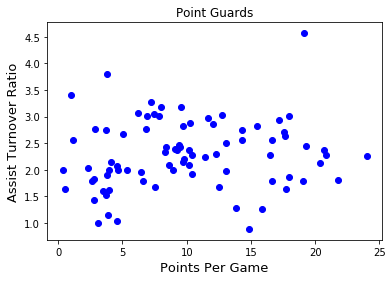

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(point_guards['ppg'], point_guards['atr'], c='b')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)

#### The Algorithm
Setup K-Means is an iterative algorithm that switches between recalculating the centroid of each cluster and the players that belong to that cluster. To start, select 5 players at random and assign their coordinates as the initial centroids of the just created clusters.

Step 1 (Assign to Cluster) For each player, calculate the Euclidean distance between that player's coordinates, or values for atr & ppg, and each of the centroids' coordinates. Assign the player to the cluster whose centroid is the closest to, or has the lowest Euclidean distance to, the player's values.

Step 2 (Recalculate Centroids) For each cluster, compute the new centroid by calculating the geometric mean of all of the points (players) in that cluster. We calculate the geometric mean by taking the average of all of the X values (atr) and the average of all of the Y values (ppg) of the points in that cluster.

Iterate Repeat steps 1 & 2 until the clusters are no longer moving and have converged.

In [13]:
import numpy as np
import random

num_clusters = 5

# Use numpy's random function to generate a list, length: num_clusters, of indices.
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)

# Use the random indices to create the centroids.
centroids = point_guards.ix[random_initial_points]

C:\Users\Kiran\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


#### Visualize Centroids
Let's plot the centroids, in addition to the point_guards, so we can see where the randomly chosen centroids started out.

Text(0, 0.5, 'Assist Turnover Ratio')

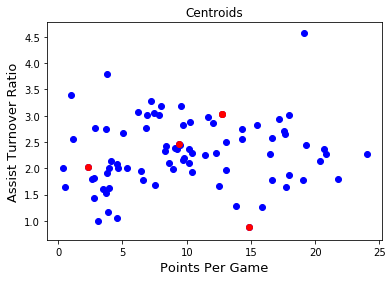

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(point_guards['ppg'], point_guards['atr'], c='b')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)

#### While the centroids data frame object worked well for the initial centroids, where the centroids were just a subset of players, as we iterate the centroids' values will be coordinates that may not match another player's coordinates. Moving forward, let's use a dictionary object instead to represent the centroids.

We will need a unique identifier, like cluster_id, to refer to each cluster's centroid and a list representation of the centroid's coordinates (or values for ppg and atr). Let's create a dictionary then with the following mapping:

* key: `cluster_id` of that centroid's cluster
* value: centroid's coordinates expressed as a list ( `ppg` value first, `atr` value second )

To generate the cluster_ids, let's iterate through each centroid and assign an integer from 0 to k-1. For example, the first centroid will have a cluster_id of 0, while the second one will have a cluster_id of 1. We'll write a function, centroids_to_dict, that takes in the centroids data frame object, creates a cluster_id and converts the ppg and atr values for that centroid into a list of coordinates, and adds both the cluster_id and coordinates_list into the dictionary that's returned.

In [16]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # Iterating counter we use to generate a cluster_id.
    counter = 0

    # Iterate a pandas data frame row-wise using .iterrows().
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)
print("centroids_dict", centroids_dict)

centroids_dict {0: [2.3548387096774195, 2.032258064516129], 1: [12.785714285714286, 3.0229007633587788], 2: [12.785714285714286, 3.0229007633587788], 3: [14.85, 0.8854166666666666], 4: [9.402777777777779, 2.463157894736842]}


#### Euclidean Distance
Before we can assign players to clusters, we need a way to compare the ppg and atr values of the players with each cluster's centroids. Euclidean distance is the most common technique used in data science for measuring distance between vectors and works extremely well in 2 and 3 dimensions. While in higher dimensions, Euclidean distance can be misleading, in 2 dimensions Euclidean distance is essentially the Pythagorean theorem.

The formula is $\sqrt{(q_1-p_1)^2 + (q_2-p_2)^2 + \cdots + (q_n-p_n)^2}$

q and p are the 2 vectors we are comparing. If q is [5, 2] and p is [3, 1], the distance comes out to:

$\sqrt{(5-3)^2 + (2-1)^2} = \sqrt{5} = ~2.23607$

Let's create the function calculate_distance, which takes in 2 lists (the player's values for ppg and atr and the centroid's values for ppg and atr).

In [17]:
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print("calculate_distance(q, p)", calculate_distance(q, p))

calculate_distance(q, p) 2.23606797749979


#### Step 1 (Assign to Cluster)
Now we need a way to assign data points to clusters based on Euclidean distance. Instead of creating a new variable or data structure to house the clusters, let's keep things simple and just add a column to the point_guards data frame that contains the cluster_id of the cluster it belongs to.

Instructions
Create a function that can be applied to every row in the data set (using the apply function in pandas). For each player, we want to calculate the distances to each cluster's centroid using euclidean_distance. Once we know the distances, we can determine which centroid is the closest (has the lowest distance) and return that centroid's cluster_id.

Create a new column, cluster, that contains the row-wise results of assign_to_cluster.

In [18]:
def assign_to_cluster(row):
    lowest_distance = -1
    closest_cluster = -1
    
    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']]
        euclidean_distance = calculate_distance(centroid, df_row)
        
        if lowest_distance == -1:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id 
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

#### Let's write a function, visualize_clusters, that we can use to visualize the clusters easily.

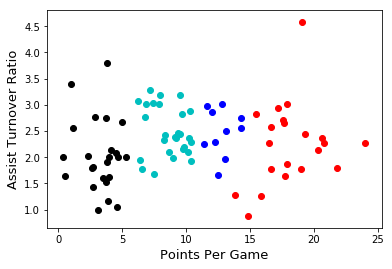

In [19]:
# Visualizing clusters
def visualize_clusters(df, num_clusters):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)

visualize_clusters(point_guards, 5)

#### Step 2 (Recalculate Centroids)
Instructions
Finish the function, recalculate_centroids, that takes in the point_guards data frame object, uses each cluster_id(from 0 to num_clusters - 1) to pull out all of the players in each cluster, calculates the new geometric mean, and adds the cluster_id and the new geometric mean to new_centroids_dict, the final dictionary to be returned.

In [20]:
def recalculate_centroids(df):
    new_centroids_dict = dict()
    
    for cluster_id in range(0, num_clusters):
        values_in_cluster = df[df['cluster'] == cluster_id]
        # Calculate new centroid using mean of values in the cluster.
        new_centroid = [np.average(values_in_cluster['ppg']), np.average(values_in_cluster['atr'])]
        new_centroids_dict[cluster_id] = new_centroid
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)
print("centroids_dict:", centroids_dict)

centroids_dict: {0: [3.2510322129176843, 2.032060176491893], 1: [12.754161652973593, 2.484569724420345], 2: [nan, nan], 3: [18.14615684101367, 2.25588338075124], 4: [8.614448825166612, 2.489817106264363]}


C:\Users\Kiran\Anaconda3\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Kiran\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Repeat Step 1 (Assign to Cluster)
Now that we recalculated the centroids, let's re-run Step 1 (assign_to_cluster) and see how the clusters shifted.

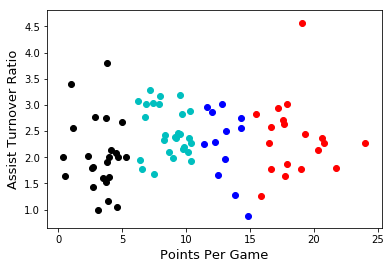

In [21]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

#### Repeat Step 2 (Recalculate Centroids) and Step 1 (Assign to Cluster)
Now we need to recalculate the centroids, and shift the clusters again.

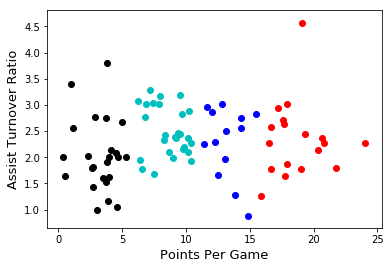

In [22]:
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

#### Challenges of K-Means
As you repeat Steps 1 and 2 and run visualize_clusters, you'll notice that a few of the points are changing clusters between every iteration (especially in areas where 2 clusters almost overlap), but otherwise, the clusters visually look like they don't move a lot after every iteration. This means 2 things:

K-Means doesn't cause massive changes in the makeup of clusters between iterations, meaning that it will always converge and become stable
Because K-Means is conservative between iterations, where we pick the initial centroids and how we assign the players to clusters initially matters a lot
To counteract these problems, the sklearn implementation of K-Means does some intelligent things like re-running the entire clustering process lots of times with random initial centroids so the final results are a little less biased on one passthrough's initial centroids.

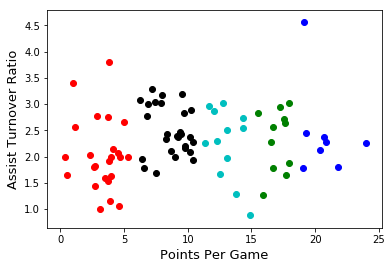

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)

#### Conclusion
In this lesson, we explored how to segment NBA players into groups with similar traits. Our exploration helped us get a sense of the 5 types of point guards as based on each player's Assist Turnover Ratio and Points Per Game. In future lessons, we will explore how to cluster using many more features, as well as alternative ways of clustering data without using centroids.

We also got to experience the beautify of sklearn and the simplicity of using sophisticated models to get what we need accomplished quickly. In just a few lines, we ran and visualized the results of a robust K-means clustering implementation. When using K-means in the real world, use the sklearn implementation.